The following project presents a real-world example of a machine learning model developed for a multinational telecommunications company. The model’s objective is to predict whether an invoice issued to a sister company will be paid or not. Since these sister companies operate globally, a version of the model incorporating macroeconomic variables was also included in the analysis. The data is anonimyzed and transformed for security reasons. 

The next process were applied to the workflow:
- [Data Exploratory Analysis (Distributions, frequencies, heatmaps, etc.)](#1)
- [Data Cleaning (informative/intelligent imputation, multicollinearity analysis, etc.)](#2)
- [Feature Engineering (Variables creation within the dataset and from external sources, etc.)](#3)
- [Model Selection (Fine-tune hyperparameters, ensemble methods, adressing class imbalance, etc.)](#4)
- [Model Evaluation (ROC curve, confusion matrix, variable importance evaluation, etc.)](#5)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import io
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
from itertools import combinations
import time
import joblib

In [2]:
# Set the document path to the current directory
base_path = os.getcwd()

# Read the data file
df = pd.read_csv(os.path.join(base_path, "data.csv"))

# <a id='1'>Data Exploratory Analysis</a>

In [3]:
### Data Exploration ###
df.shape

(849400, 26)

In [4]:
# Check column names and variable types
df.dtypes

PROVEEDOR_BANCARROTA               int64
PROVEEDOR_BAD_DEBT                 int64
FECHA_FACTURA                     object
FECHA_ANIO_PRESUPESTARIO          object
FECHA_CREACION_FACTURA            object
CODIGO_COMPRAS                    object
MONEDA_FACTURA                    object
TIPO_GASTO                        object
OPERADORA                         object
OPERADORA_PAIS                    object
AREA_ROSETA_NIVEL_2               object
PROVEEDOR                         object
PROVEEDOR_PAIS                    object
PROVEEDOR_TIPO                    object
PROVEEDOR_CONCILIADO               int64
PROVEEDOR_TIENE_GRUPO              int64
PROVEEDOR_GRUPO                   object
PROVEEDOR_LOGISTICO                int64
PROVEEDOR_BLOQUEADO_ALGUNA_VEZ     int64
CONDICION_DE_PAGO                 object
ISSUE_DATE                        object
FECHA_CIERRE                      object
COBRADO                            int64
PORCENTAJE_COBRADO                object
FEE_FACTURAS_EUR

Since the company is from Spain, the dataset is originally in Spanish. 
For the purpose of presenting this work to future employers, I will translate the variable names into English.
However, in the real application, they use a Spanish version of this work.

In [5]:
# Translate the variable names from Spanish to English
df.rename(columns={
    'PROVEEDOR_BANCARROTA': 'SUPPLIER_BANKRUPTCY',
    'PROVEEDOR_BAD_DEBT': 'SUPPLIER_BAD_DEBT',
    'FECHA_FACTURA': 'DATE_INVOICE',
    'FECHA_ANIO_PRESUPESTARIO': 'DATE_BUDGET_YEAR',
    'FECHA_CREACION_FACTURA': 'DATE_INVOICE_CREATION',
    'CODIGO_COMPRAS': 'PURCHASE_CODE',
    'MONEDA_FACTURA': 'INVOICE_CURRENCY',
    'TIPO_GASTO': 'EXPENSE_TYPE',
    'OPERADORA': 'OPERATOR',
    'OPERADORA_PAIS': 'OPERATOR_COUNTRY',
    'AREA_ROSETA_NIVEL_2': 'ROSETTE_AREA_LEVEL_2',
    'PROVEEDOR': 'SUPPLIER',
    'PROVEEDOR_PAIS': 'SUPPLIER_COUNTRY',
    'PROVEEDOR_TIPO': 'SUPPLIER_TYPE',
    'PROVEEDOR_CONCILIADO': 'SUPPLIER_RECONCILED',
    'PROVEEDOR_TIENE_GRUPO': 'SUPPLIER_HAS_GROUP',
    'PROVEEDOR_GRUPO': 'SUPPLIER_GROUP',
    'PROVEEDOR_LOGISTICO': 'SUPPLIER_LOGISTICS',
    'PROVEEDOR_BLOQUEADO_ALGUNA_VEZ': 'SUPPLIER_EVER_BLOCKED',
    'CONDICION_DE_PAGO': 'PAYMENT_CONDITION',
    'FECHA_EMISION': 'ISSUE_DATE',
    'FECHA_CIERRE': 'CLOSING_DATE',
    'COBRADO': 'COLLECTED',
    'PORCENTAJE_COBRADO': 'PERCENT_COLLECTED',
    'FEE_FACTURAS_EUROS': 'INVOICE_FEE_EUROS',
    'FEE_FACTURAS': 'INVOICE_FEE'
}, inplace=True)

In [6]:
# Check some values to get a better understanding of the variable values
df.head()

,SUPPLIER_BANKRUPTCY,SUPPLIER_BAD_DEBT,DATE_INVOICE,DATE_BUDGET_YEAR,DATE_INVOICE_CREATION,PURCHASE_CODE,INVOICE_CURRENCY,EXPENSE_TYPE,OPERATOR,OPERATOR_COUNTRY,...,SUPPLIER_GROUP,SUPPLIER_LOGISTICS,SUPPLIER_EVER_BLOCKED,PAYMENT_CONDITION,ISSUE_DATE,CLOSING_DATE,COLLECTED,PERCENT_COLLECTED,INVOICE_FEE_EUROS,INVOICE_FEE
0,0,0,8/1/1900,1/1/1900,1/5/2022,EE24E6C2,13F1D5D96,1D51539BA,128035CDA,BR,...,1DAEE887E,0,1,171A7B8C0,8/5/2022,29/06/2022,1,1,"32,361,960,159","32,361,960,159"
1,0,0,22/11/2006,1/1/2006,22/02/2018,EE24E6C2,C23AED0A,B9E488,1C95A2E33,ES,...,3C41895,0,0,13D63C67D,22/02/2018,22/05/2018,1,1,"26,195,378,167","26,195,378,167"
2,0,0,22/03/2009,1/1/2009,8/12/2019,1CD269ACD,C23AED0A,1D51539BA,21713500B,ES,...,20F7725D7,0,1,13D63C67D,15/12/2019,22/04/2020,1,1,"31,894,778,021","31,894,778,021"
3,0,0,1/7/2009,1/1/2009,29/09/2020,1CD269ACD,C23AED0A,1D51539BA,2C28F1A6,ES,...,20F7725D7,0,0,1C390D618,29/09/2020,22/05/2021,1,1,"24,489,883,051","24,489,883,051"
4,0,0,22/12/2009,1/1/2009,29/01/2018,153F61B66,C23AED0A,1D51539BA,A75A9F10,ES,...,201DB2A4F,0,0,4098EB9E,8/3/2018,8/9/2018,1,1,"27,442,656,203","27,442,656,203"


__General Observations__ <br>
1.- All integer variables appear to take values of either 0 or 1. This means they represent binary categorical variables. <br>
2.- INVOICE_FEE and INVOICE_FEE_EUROS contain continuous numeric values. Currently stored as object type → should be cast to numeric. <br>
3.- The first row is certainly an error in data collection, since the invoice date is 1900, the date columns should be explored. <br>
4.- The dates are currently stored as object type, they should be converted to a proper date format for easier handling and analysis. <br>
5.- It seems that the variable DATE_BUDGET_YEAR it's the same date as DATE_INVOICE, but only for the years, this should be confirmed.

In [7]:
# Confirm that the Integer variables have only 1's and 0's values.
np.unique(df[['SUPPLIER_BANKRUPTCY', 'SUPPLIER_BAD_DEBT', 'SUPPLIER_RECONCILED', 'SUPPLIER_HAS_GROUP', 'SUPPLIER_LOGISTICS', 
             'SUPPLIER_EVER_BLOCKED', 'COLLECTED']].values)

array([0, 1], dtype=int64)

In [8]:
# Convert object type variable to numeric, replacing commas.
df['INVOICE_FEE'] = pd.to_numeric(df['INVOICE_FEE'].str.replace(',', ''), errors='coerce')
df['INVOICE_FEE_EUROS'] = pd.to_numeric(df['INVOICE_FEE_EUROS'].str.replace(',', ''), errors='coerce')

# Convert object type date variables to date format.
df['DATE_INVOICE'] = pd.to_datetime(df['DATE_INVOICE'], format='%d/%m/%Y')
df['DATE_BUDGET_YEAR'] = pd.to_datetime(df['DATE_BUDGET_YEAR'], format='%d/%m/%Y')
df['DATE_INVOICE_CREATION'] = pd.to_datetime(df['DATE_INVOICE_CREATION'], format='%d/%m/%Y')

# Check column names and variable types to confirm transformation
df.dtypes

SUPPLIER_BANKRUPTCY               int64
SUPPLIER_BAD_DEBT                 int64
DATE_INVOICE             datetime64[ns]
DATE_BUDGET_YEAR         datetime64[ns]
DATE_INVOICE_CREATION    datetime64[ns]
PURCHASE_CODE                    object
INVOICE_CURRENCY                 object
EXPENSE_TYPE                     object
OPERATOR                         object
OPERATOR_COUNTRY                 object
ROSETTE_AREA_LEVEL_2             object
SUPPLIER                         object
SUPPLIER_COUNTRY                 object
SUPPLIER_TYPE                    object
SUPPLIER_RECONCILED               int64
SUPPLIER_HAS_GROUP                int64
SUPPLIER_GROUP                   object
SUPPLIER_LOGISTICS                int64
SUPPLIER_EVER_BLOCKED             int64
PAYMENT_CONDITION                object
ISSUE_DATE                       object
CLOSING_DATE                     object
COLLECTED                         int64
PERCENT_COLLECTED                object
INVOICE_FEE_EUROS               float64


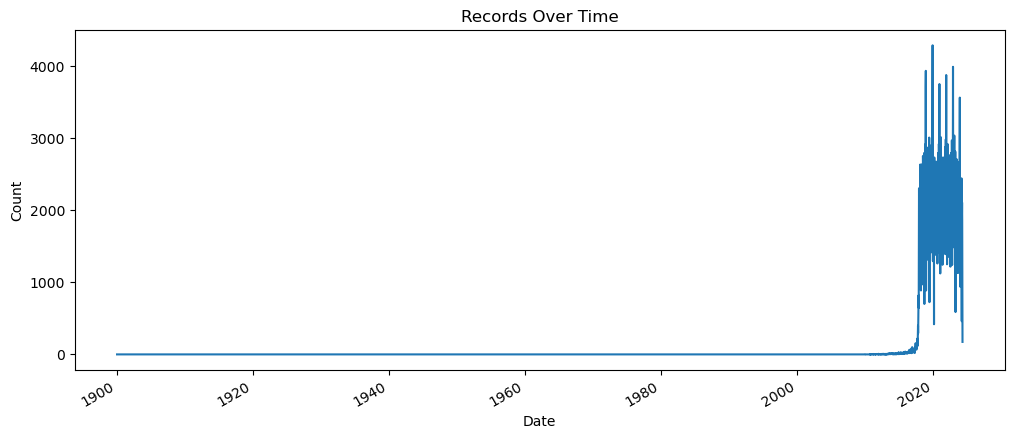

In [9]:
# Let's explore the data type columns to address the error spotted in the first rows of the dataset.
# Let's observe the records over time to understand the date distribution in our dataset
df.groupby('DATE_INVOICE').size().plot(figsize=(12,5))
plt.title("Records Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

Most of the dates appear to fall around 2020, with few apparent outliers. To confirm this, we will count the number of records for each unique year

In [10]:
print(df['DATE_INVOICE'].dt.year.value_counts().sort_index())

DATE_INVOICE
1900         1
2006         1
2009         5
2010        56
2011       205
2012       240
2013       400
2014       561
2015      1182
2016      2192
2017     15168
2018    129454
2019    136173
2020    132665
2021    132203
2022    134651
2023    128462
2024     35781
Name: count, dtype: int64


In [11]:
# There are only two clear outliers; we should remove them.
df = df.iloc[2:]

# Create a boolean column that is True if the years match between DATE_BUDGET_YEAR and DATE_INVOICE.
df['SAME_YEAR'] = df['DATE_BUDGET_YEAR'].dt.year == df['DATE_INVOICE'].dt.year

# Check if all rows have the same year, .all() returns True if all elements are True.
print(df['SAME_YEAR'].all())

True


C:\Users\beltr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\beltr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


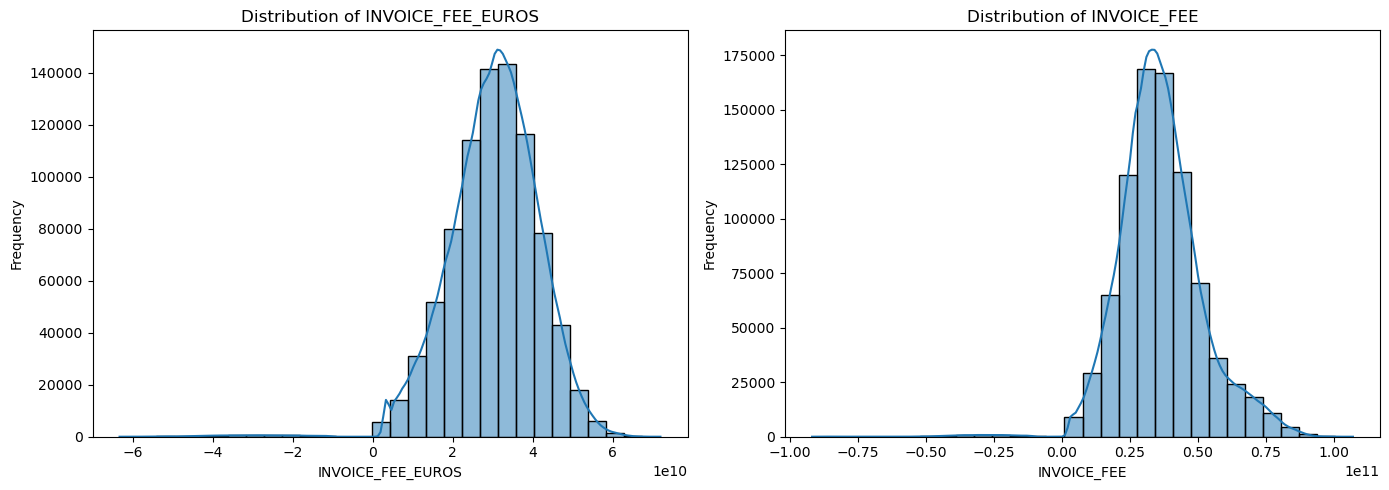

In [12]:
# DATE_BUDGET_YEAR variable, along with the boolean column we created, can be dropped since they do not provide any additional information.
df = df.drop(columns=['DATE_BUDGET_YEAR', 'SAME_YEAR'])

# Continuing with the EDA, we are interested in seeing the distribution of our continuous (float) variables, which are only two.
# List of continuous variables
cont_vars = ['INVOICE_FEE_EUROS', 'INVOICE_FEE']  # replace with your variable names

# Create subplots side by side to compare their behavior
fig, axes = plt.subplots(1, 2, figsize=(14,5))
for i, var in enumerate(cont_vars):
    sns.histplot(df[var], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

We observe two important things: <br>
1 - Both variables approximately follow a Gaussian distribution. <br>
2 - The right tail of the distributions behaves differently. <br>
Based on the variable names, it was assumed that the two quantities represented the same measure, but one in Euros and the other in Dollars.
However, the differing behavior in the right tail indicates that the continuous variable FEE_FACTURAS is not measured solely in dollars.
It appears to include multiple currencies, which explains both the tail differences and the significant discrepancies in the values.
Based on this information, we can drop the aforementioned variable, since it is measured in multiple currencies and therefore not consistent.


In [13]:
df = df.drop(columns=['INVOICE_FEE'])

# <a id='2'>Data Cleaning</a>

In [14]:
# We check if there are any Null values in the dataset
print(df.isnull().sum())

SUPPLIER_BANKRUPTCY          0
SUPPLIER_BAD_DEBT            0
DATE_INVOICE                 0
DATE_INVOICE_CREATION        0
PURCHASE_CODE                0
INVOICE_CURRENCY             0
EXPENSE_TYPE                 0
OPERATOR                     0
OPERATOR_COUNTRY             0
ROSETTE_AREA_LEVEL_2         0
SUPPLIER                     0
SUPPLIER_COUNTRY             0
SUPPLIER_TYPE                0
SUPPLIER_RECONCILED          0
SUPPLIER_HAS_GROUP           0
SUPPLIER_GROUP               0
SUPPLIER_LOGISTICS           0
SUPPLIER_EVER_BLOCKED        0
PAYMENT_CONDITION            0
ISSUE_DATE               44016
CLOSING_DATE             94801
COLLECTED                    0
PERCENT_COLLECTED        44016
INVOICE_FEE_EUROS          404
dtype: int64


In [15]:
# Three variables contain null values. Based on their names, they appear to be related to the target variable "COLLECTED".
# We will investigate whether there is a meaningful connection.

# Count the frequency of each category
print(df['COLLECTED'].value_counts())

COLLECTED
1    754597
0     94801
Name: count, dtype: int64


In [16]:
# We discovered that the null values exist because the information is captured when the invoice is paid.
# Therefore, we drop the columns with null values since they will have perfect correlation with our objective variable
df = df.drop(columns=['ISSUE_DATE', 'CLOSING_DATE', 'PERCENT_COLLECTED'])

In [17]:
# The other variable with missing values is INVOICE_FEE_EUROS.
# We explore those rows with missing values to see if we spot any possible logic behind them.
# Show rows where FEE_FACTURAS_EUROS is missing
df[df['INVOICE_FEE_EUROS'].isna()]

,SUPPLIER_BANKRUPTCY,SUPPLIER_BAD_DEBT,DATE_INVOICE,DATE_INVOICE_CREATION,PURCHASE_CODE,INVOICE_CURRENCY,EXPENSE_TYPE,OPERATOR,OPERATOR_COUNTRY,ROSETTE_AREA_LEVEL_2,...,SUPPLIER_COUNTRY,SUPPLIER_TYPE,SUPPLIER_RECONCILED,SUPPLIER_HAS_GROUP,SUPPLIER_GROUP,SUPPLIER_LOGISTICS,SUPPLIER_EVER_BLOCKED,PAYMENT_CONDITION,COLLECTED,INVOICE_FEE_EUROS
1179,0,0,2014-10-22,2019-08-22,20F409F5D,17904787D,B9E488,90EE119,AR,17B2DCCCA,...,AR,1C1F88434,1,1,12B122361,0,1,1FB9FA227,1,NaN
3477,0,0,2016-08-22,2019-04-22,6E0CE924,C23AED0A,1B12D65A0,136A2C8DF,DE,CE34CA55,...,DE,1C1F88434,1,1,9ABFC21C,0,1,504CF739,0,NaN
6856,0,0,2017-08-15,2018-10-22,EE24E6C2,C23AED0A,1D51539BA,1104BFF3D,ES,20B5EA793,...,ES,10B762497,0,1,225CD32EF,0,0,171A7B8C0,1,NaN
13107,0,0,2017-12-08,2018-01-08,EE24E6C2,C23AED0A,1D51539BA,1104BFF3D,ES,20B5EA793,...,ES,10B762497,0,1,225CD32EF,0,0,1C390D618,1,NaN
17144,0,0,2017-12-22,2018-01-29,6E0CE924,E4164C9B,1D51539BA,1F1CD3122,UK,C92DC5BA,...,GB,1C1F88434,1,1,9ABFC21C,0,1,1FB9FA227,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795947,0,0,2024-01-08,2024-01-29,20F409F5D,C23AED0A,B9E488,1104BFF3D,ES,20B5EA793,...,ES,DC75DA79,0,1,20EA1C846,0,0,4098EB9E,1,NaN
802811,0,0,2024-02-01,2024-02-08,20F409F5D,E4164C9B,B9E488,1F1CD3122,UK,C92DC5BA,...,FI,1C1F88434,0,1,201DB2A4F,0,1,4098EB9E,0,NaN
802822,0,0,2024-02-01,2024-02-08,6E0CE924,13F1D5D96,1B12D65A0,128035CDA,BR,17D17F139,...,BR,1C1F88434,1,1,1DAEE887E,0,1,1C390D618,0,NaN
812460,0,0,2024-03-01,2024-03-15,20F409F5D,C23AED0A,1D51539BA,1104BFF3D,ES,20B5EA793,...,ES,DC75DA79,0,0,20F7725D7,0,0,4098EB9E,0,NaN


In [18]:
# We cannot see any pattern in the few missing observations, so it was decided to do informative imputation
# We try to understand which categorical value is better for doing mean imputation by observing the F-statistic, p-value, and eta-squared.
# We choose the few categorical variables that make the most sense to compare with theoretically.
def eta_squared(y, x):
    groups = [y[x == cat] for cat in np.unique(x)]
    ss_between = sum(len(g) * (g.mean() - y.mean())**2 for g in groups)
    ss_total = sum((y - y.mean())**2)
    return ss_between / ss_total

# Categorical variables in English
categorical_vars = ['PURCHASE_CODE', 'EXPENSE_TYPE', 'OPERATOR', 
                    'SUPPLIER_TYPE', 'SUPPLIER']

results = []

for cat in categorical_vars:
    groups = [group["INVOICE_FEE_EUROS"].dropna().values 
              for name, group in df.groupby(cat)]
    
    if len(groups) > 1:
        f_stat, p_val = stats.f_oneway(*groups)
        eta_sq = eta_squared(df['INVOICE_FEE_EUROS'].dropna(), df[cat].dropna())
        results.append((cat, f_stat, p_val, eta_sq))
    else:
        results.append((cat, None, None, None))

for cat, f, p, eta in results:
    if f is not None:
        print(f"{cat}: F = {f:.2f}, p = {p:.4e}, eta² = {eta:.3f}")
    else:
        print(f"{cat}: Not enough groups")

PURCHASE_CODE: F = 7939.02, p = 0.0000e+00, eta² = 0.053
EXPENSE_TYPE: F = 14132.28, p = 0.0000e+00, eta² = 0.048
OPERATOR: F = 308.37, p = 0.0000e+00, eta² = 0.057
SUPPLIER_TYPE: F = 9594.41, p = 0.0000e+00, eta² = 0.064
SUPPLIER: F = 38.72, p = 0.0000e+00, eta² = 0.326


The ETA squared (η²) analysis measures the effect size: how much variance in the continuous variable (INVOICE_FEE_EUROS) is explained by each categorical variable. <br>
SUPPLIER variable has the highest eta value. It explains (~32.6%) of the variance in invoice fees.

In [19]:
# We use the mean of the corresponding "SUPPLIER" to do the imputation.
df['INVOICE_FEE_EUROS'] = df.groupby('SUPPLIER')['INVOICE_FEE_EUROS']\
                              .transform(lambda x: x.fillna(x.mean()))

We have analyzed and cleaned our continuous and date variables; next, we will perform the same process for our categorical variables.

In [20]:
# First, let's observe the number of unique values for each categorical variable.
categorical_vars = df.select_dtypes(include=['object', 'category']).columns
unique_counts = df[categorical_vars].nunique().sort_values(ascending=False)
print(unique_counts)

SUPPLIER                10473
SUPPLIER_GROUP           1882
OPERATOR                  167
SUPPLIER_COUNTRY           68
OPERATOR_COUNTRY           25
ROSETTE_AREA_LEVEL_2       23
INVOICE_CURRENCY           21
PAYMENT_CONDITION          14
PURCHASE_CODE               7
SUPPLIER_TYPE               7
EXPENSE_TYPE                4
dtype: int64


Some categorical variables have a very high number of unique values, which would make one-hot encoding inefficient.<br>
Therefore, we will aim to remove variables that are highly correlated with others to avoid creating hundreds of predictors in our model.

In [21]:
# We check the correlation of categorical variables with the chi-squared test.
categorical_vars = df.select_dtypes(include=['object', 'category']).columns
def chi2_all_categorical(df, categorical_vars):
    results = []
    
    for var1, var2 in combinations(categorical_vars, 2):
        # Create contingency table
        contingency = pd.crosstab(df[var1], df[var2])
        
        # Apply Chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency)
        
        results.append({
            'Variable1': var1,
            'Variable2': var2,
            'Chi2': chi2,
            'dof': dof
        })
    
    return pd.DataFrame(results).sort_values('Chi2')

print(chi2_all_categorical(df, categorical_vars))

               Variable1             Variable2          Chi2       dof
10      INVOICE_CURRENCY          EXPENSE_TYPE  4.284185e+04        60
20          EXPENSE_TYPE      OPERATOR_COUNTRY  5.519148e+04        72
24          EXPENSE_TYPE         SUPPLIER_TYPE  5.929578e+04        18
3          PURCHASE_CODE      OPERATOR_COUNTRY  7.073983e+04       144
21          EXPENSE_TYPE  ROSETTE_AREA_LEVEL_2  7.147163e+04        66
23          EXPENSE_TYPE      SUPPLIER_COUNTRY  8.075259e+04       201
0          PURCHASE_CODE      INVOICE_CURRENCY  8.979214e+04       120
37      OPERATOR_COUNTRY         SUPPLIER_TYPE  9.056229e+04       144
7          PURCHASE_CODE         SUPPLIER_TYPE  9.140992e+04        36
16      INVOICE_CURRENCY         SUPPLIER_TYPE  9.612048e+04       120
9          PURCHASE_CODE     PAYMENT_CONDITION  1.162787e+05        78
6          PURCHASE_CODE      SUPPLIER_COUNTRY  1.248043e+05       402
42  ROSETTE_AREA_LEVEL_2         SUPPLIER_TYPE  1.277868e+05       132
26    

We observe that the correlations between categorical variables are very high according to the Chi² values.<br>
The degrees of freedom are also very large, which is expected given the high number of unique values.<br>
<br>
Logically, variables such as SUPPLIER, SUPPLIER_GROUP, and SUPPLIER_COUNTRY are strongly correlated, since a supplier always belongs to the same group and country. Therefore, we can confidently remove categorical variables that have many unique values and exhibit strong correlations with other variables to reduce dimensionality and redundancy.
<br>
<br>
The variable 'OPERATOR' shows strong correlations with other variables. However, it is likely very important for our model, as the operator is theoretically strongly related to the invoice collected, and multicollinearity doesn’t harm ensemble model performance., We opted to include the variable in the modelling. 

In [22]:
df = df.drop(columns=['SUPPLIER', 'SUPPLIER_GROUP', 'ROSETTE_AREA_LEVEL_2'])

In [23]:
# Next, we compute a Cramér's V matrix for the remaining categorical variables to identify if any strong associations still exist among them.
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r-1, k-1))))

def cramers_v_matrix(df):
    # Select only categorical/object columns
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    n = len(cat_cols)
    
    # Initialize empty matrix
    results = pd.DataFrame(np.zeros((n, n)), index=cat_cols, columns=cat_cols)
    
    # Compute pairwise Cramér's V
    for i in range(n):
        for j in range(i, n):
            if i == j:
                results.iloc[i, j] = 1.0
            else:
                table = pd.crosstab(df[cat_cols[i]], df[cat_cols[j]])
                v = cramers_v(table)
                results.iloc[i, j] = v
                results.iloc[j, i] = v 
    
    return results

v_matrix = cramers_v_matrix(df)
print(v_matrix)


                   PURCHASE_CODE  INVOICE_CURRENCY  EXPENSE_TYPE  OPERATOR  \
PURCHASE_CODE           1.000000          0.132736      0.497958  0.243600   
INVOICE_CURRENCY        0.132736          1.000000      0.129664  0.653251   
EXPENSE_TYPE            0.497958          0.129664      1.000000  0.253729   
OPERATOR                0.243600          0.653251      0.253729  1.000000   
OPERATOR_COUNTRY        0.117815          0.646603      0.147170  1.000000   
SUPPLIER_COUNTRY        0.156489          0.694573      0.178017  0.462305   
SUPPLIER_TYPE           0.133926          0.137334      0.152544  0.217763   
PAYMENT_CONDITION       0.151049          0.146984      0.226726  0.221713   

                   OPERATOR_COUNTRY  SUPPLIER_COUNTRY  SUPPLIER_TYPE  \
PURCHASE_CODE              0.117815          0.156489       0.133926   
INVOICE_CURRENCY           0.646603          0.694573       0.137334   
EXPENSE_TYPE               0.147170          0.178017       0.152544   
OPERATOR 

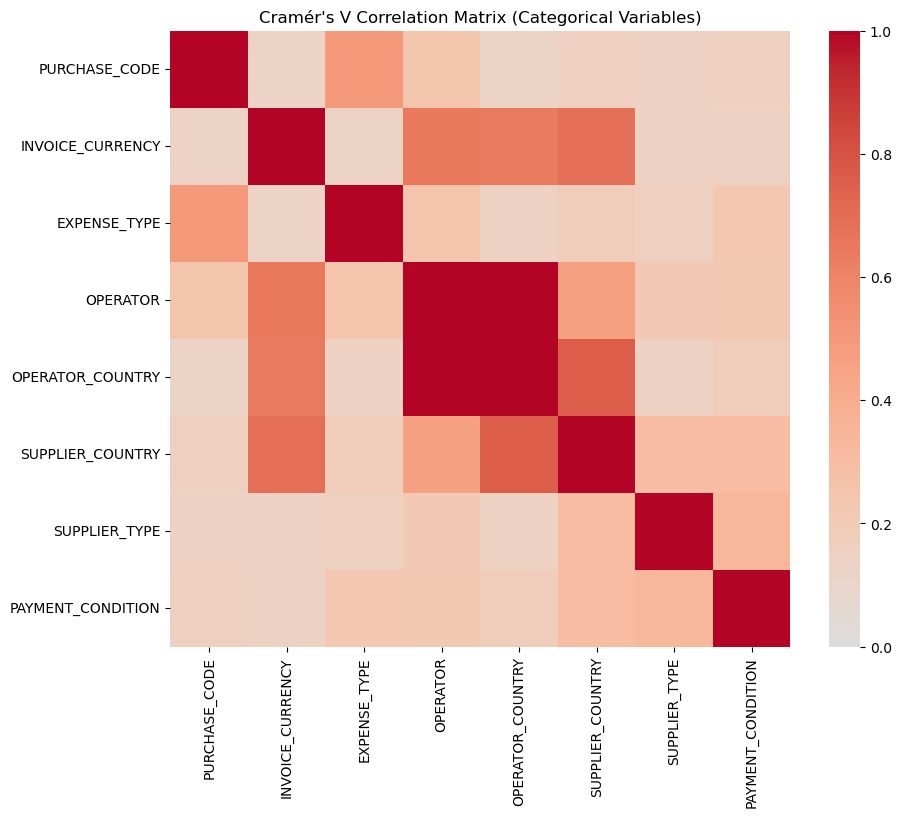

In [24]:
# We build a heatmap for visualizing the association, so we can notice the correlation more easily
plt.figure(figsize=(10,8))
sns.heatmap(v_matrix, annot=False, cmap="coolwarm", center=0, vmin=0, vmax=1)
plt.title("Cramér's V Correlation Matrix (Categorical Variables)")
plt.show()

OPERATOR and OPERATOR_COUNTRY show a very high correlation. Because of the theoretical importance of the variable OPERATOR, we are going to keep that variable in our model and drop OPERATOR_COUNTRY, however, in our project workflow, we will keep OPERATOR_COUNTRY temporarily, as it is needed to import macroeconomic variables into the model.<br>
INVOICE_CURRENCY is other variable that is correlated, we can drop it. <br>
EXPENSE_TYPE and PURCHASE_CODE also show some correlation, but since they have few unique values, we decided to keep them both.

In [25]:
# Drop INVOICE_CURRENCY
df = df.drop(columns=['INVOICE_CURRENCY'])

# Let's explore the remaining categorical variables in our model
# Select only categorical variables (object or category dtype)
categorical_vars = df.select_dtypes(include=['object', 'category']).columns

# Count unique values
unique_counts = df[categorical_vars].nunique().sort_values(ascending=False)

# Display results
print(unique_counts)

OPERATOR             167
SUPPLIER_COUNTRY      68
OPERATOR_COUNTRY      25
PAYMENT_CONDITION     14
PURCHASE_CODE          7
SUPPLIER_TYPE          7
EXPENSE_TYPE           4
dtype: int64


Four of the remaining categorical variables have more than 10 unique values each. We will group the less frequent categories into an 'Other' category to reduce the number of dummy variables and improve model efficiency.<br>
After some testing, we decided that .26% threshold is appropriate for grouping less frequent categories. The variable OPERATOR_COUNTRY will remain unchanged, as it is needed for importing external data.

In [26]:
# List of categorical variables to group rare categories
categorical_vars = ['OPERATOR', 'SUPPLIER_COUNTRY', 'PAYMENT_CONDITION', 'OPERATOR_COUNTRY']

# Apply grouping on the working DataFrame
for var in categorical_vars:
    counts = df[var].value_counts(normalize=True)
    rare = counts[counts < 0.0026].index
    df[var] = df[var].replace(rare, 'Other')

# Check the unique values again
categorical_vars = df.select_dtypes(include=['object', 'category']).columns
unique_counts = df[categorical_vars].nunique().sort_values(ascending=False)

# Display results
print(unique_counts)

OPERATOR             41
SUPPLIER_COUNTRY     22
OPERATOR_COUNTRY     19
PAYMENT_CONDITION    10
PURCHASE_CODE         7
SUPPLIER_TYPE         7
EXPENSE_TYPE          4
dtype: int64


# <a id='3'>Feature Engineering</a>

Now is time to create new variables for our dataset.<br>
We will create first some variables with the data that we already have and after we will import external data based on macroeconomic variables.<br>
First, let's do some feature engineering with the date columns.

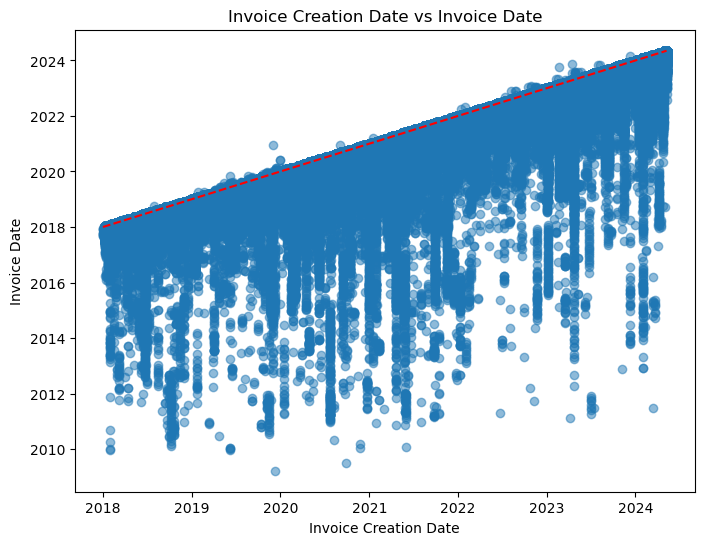

In [27]:
# We have two date columns: DATE_INVOICE_CREATION and DATE_INVOICE. We can assume that one is the initial date of the invoice, and the other
# a date that represents a further step in the process. Let's build a scatter plot to check which date usually comes first.
# Scatter plot with diagonal reference line
plt.figure(figsize=(8,6))
plt.scatter(df['DATE_INVOICE_CREATION'], df['DATE_INVOICE'], alpha=0.5)
plt.plot([df['DATE_INVOICE_CREATION'].min(), df['DATE_INVOICE_CREATION'].max()],
         [df['DATE_INVOICE_CREATION'].min(), df['DATE_INVOICE_CREATION'].max()],
         color='red', linestyle='--')
plt.xlabel('Invoice Creation Date')
plt.ylabel('Invoice Date')
plt.title('Invoice Creation Date vs Invoice Date')
plt.show()

We observe that most points fall below the red dotted line, which represents the same dates. This indicates that, in most cases, the INVOICE_CREATION_DATE occurs after the INVOICE_DATE, confirming our initial assumption. Therefore, we can create a new column representing the difference in days between the two dates.

In [28]:
# We create a new column that will be the difference in days between the two dates
df['DAYS_DIFFERENCE'] = (df['DATE_INVOICE_CREATION'] - df['DATE_INVOICE']).dt.days

# We can drop the DATE_INVOICE_CREATION now, since its effect is represented in the variable created DAYS_DIFFERENCE
df = df.drop(columns=['DATE_INVOICE_CREATION'])

# Now we transform the remaining date column to use it in our model, we take a column for the year and one for the month.
df["YEAR_DATE_INVOICE"] = df["DATE_INVOICE"].dt.year
df["MONTH_DATE_INVOICE"] = df["DATE_INVOICE"].dt.month

# Our month variable should be equally distributed in all months
df['MONTH_DATE_INVOICE'].value_counts().sort_index()

MONTH_DATE_INVOICE
1     66134
2     66349
3     74794
4     72663
5     66918
6     68192
7     68558
8     64788
9     69570
10    71629
11    74690
12    85113
Name: count, dtype: int64

From a financial perspective, using raw month values may not be very meaningful. It is often more useful to create a variable that represents seasonality or quarters, as these are more aligned with the company’s behavioral and financial patterns than individual months.

In [29]:
# Map months to financial seasons / quarters
season_map = {
    1: 'Q1', 2: 'Q1', 3: 'Q1',     # Jan, Feb, Mar
    4: 'Q2', 5: 'Q2', 6: 'Q2',     # Apr, May, Jun
    7: 'Q3', 8: 'Q3', 9: 'Q3',     # Jul, Aug, Sep
    10: 'Q4', 11: 'Q4', 12: 'Q4'   # Oct, Nov, Dec
}

df['SEASON'] = df['MONTH_DATE_INVOICE'].map(season_map)

# We will drop the Month variable until later because we need it to map external variables when we are doing feature engineering
#df = df.drop(columns=['MONTH'])

In [30]:
# The coronavirus had an impact on finance and economy worldwide, so, naturally, we add a dummy for that period of time. 
# Create the binary variable (seasonality variable). Define the coronavirus period
corona_start_date = pd.to_datetime('2020-01-01')
corona_end_date = pd.to_datetime('2021-12-31')
df['CORONAVIRUS_PERIOD'] = df['DATE_INVOICE'].apply(lambda x: 1 if corona_start_date <= x <= corona_end_date else 0)

### Macroeconomic Variables <br>
Now we are going to add external variables to our model, mapping the country with some macroeconomic indicators. The rationale is that a country’s economic stability can influence its operators’ ability to meet invoice payments.<br>
The data was obtained from different institutions like the World Bank, IMF, the Country's government pages, etc. However, the information found for the country of Venezuela was scarce, and it was decided to group those rows with the 'Other' country value.<br>

Additionally, we will maintain two datasets: df_2, which excludes these external variables, and df, which includes the macroeconomic indicators. This will allow us to compare model performance and handle each dataset appropriately.

The variables integrated into the macroeconomic model according to the Operator Country are:<br>
ER_SDR = Exchange Rate in SDR<br>
ER_USD = Exchange Rate in USD<br>
IR = Interest Rate<br>
UR = Unemployment Rate<br>
GDP_N = Gross Domestic Product Nominal<br>
GDP_R = Gross Domestic Product Real<br>
GDP_N_ChangeRate = Gross Domestic Product Nominal monthly change rate<br>
GDP_R_ChangeRate = Gross Domestic Product Real monthly change rate<br>
Population<br>
Inflation

In [31]:
# Create a copy of the data frame before adding the macroeconomic variables.
df_2 = df.copy()

# Grouping Venezuela with "Other".
df.loc[df['OPERATOR_COUNTRY'] == 'VE', 'OPERATOR_COUNTRY'] = 'Other'

# Load the dataset of the macroeconomic variables
ER = pd.read_excel(os.path.join(base_path, "Macro", "ExchangeRate", "ER.xlsx"))

# Convert the "Date" column in the Excel data to datetime format and extract year and month:
ER['Date'] = pd.to_datetime(ER['Date'], format='%Y-%m')
ER['YEAR_DATE_INVOICE'] = ER['Date'].dt.year
ER['MONTH_DATE_INVOICE'] = ER['Date'].dt.month
#Changing the name of Excel column so it matches the name in English of our dataset
ER.rename(columns={'OPERADORA_PAIS': 'OPERATOR_COUNTRY'}, inplace=True)

# Merging the dataframes on the common columns: 'Year', 'Month', and 'OPERADORA_PAIS'
df = pd.merge(df, ER, on=['YEAR_DATE_INVOICE', 'MONTH_DATE_INVOICE', 'OPERATOR_COUNTRY'], how='outer')

IR = pd.read_excel(os.path.join(base_path, "Macro", "InterestRate", "IR.xlsx"))

# Convert the "Date" column in the Excel data to datetime format and extract year and month:
IR['Date'] = pd.to_datetime(IR['Date'], format='%Y-%m')
IR['YEAR_DATE_INVOICE'] = IR['Date'].dt.year
IR['MONTH_DATE_INVOICE'] = IR['Date'].dt.month
#Changing the name of Excel column so it matches the name in English of our dataset
IR.rename(columns={'OPERADORA_PAIS': 'OPERATOR_COUNTRY'}, inplace=True)

# Merging the dataframes on the common columns: 'Year', 'Month', and 'OPERADORA_PAIS'
df = pd.merge(df, IR, on=['YEAR_DATE_INVOICE', 'MONTH_DATE_INVOICE', 'OPERATOR_COUNTRY'], how='outer')

UR = pd.read_excel(os.path.join(base_path, "Macro", "UnemploymentRate", "UR.xlsx"))

# Convert the "Date" column in the Excel data to datetime format and extract year and month:
UR['Date'] = pd.to_datetime(UR['Date'], format='%Y-%m')
UR['YEAR_DATE_INVOICE'] = UR['Date'].dt.year
UR['MONTH_DATE_INVOICE'] = UR['Date'].dt.month
#Changing the name of Excel column so it matches the name in English of our dataset
UR.rename(columns={'OPERADORA_PAIS': 'OPERATOR_COUNTRY'}, inplace=True)

# Merging the dataframes on the common columns: 'Year', 'Month', and 'OPERADORA_PAIS'
df = pd.merge(df, UR, on=['YEAR_DATE_INVOICE', 'MONTH_DATE_INVOICE', 'OPERATOR_COUNTRY'], how='outer')

df.drop('Date_x', axis=1, inplace=True)
df.drop('Date_y', axis=1, inplace=True)

GDP = pd.read_excel(os.path.join(base_path, "Macro", "GDP", "GDP.xlsx"))

# Convert the "Date" column in the Excel data to datetime format and extract year and month:
GDP['Date'] = pd.to_datetime(GDP['Date'], format='%Y-%m')
GDP['YEAR_DATE_INVOICE'] = GDP['Date'].dt.year
GDP['MONTH_DATE_INVOICE'] = GDP['Date'].dt.month
#Changing the name of Excel column so it matches the name in English of our dataset
GDP.rename(columns={'OPERADORA_PAIS': 'OPERATOR_COUNTRY'}, inplace=True)

# Merging the dataframes on the common columns: 'Year', 'Month', and 'OPERADORA_PAIS'
df = pd.merge(df, GDP, on=['YEAR_DATE_INVOICE', 'MONTH_DATE_INVOICE', 'OPERATOR_COUNTRY'], how='outer')

df.drop('Date_x', axis=1, inplace=True)
df.drop('Date_y', axis=1, inplace=True)

Inflation = pd.read_excel(os.path.join(base_path, "Macro", "Inflation", "Inflation.xlsx"))

# Convert the "Date" column in the Excel data to datetime format and extract year and month:
Inflation['Date'] = pd.to_datetime(Inflation['Date'], format='%Y-%m')
Inflation['YEAR_DATE_INVOICE'] = Inflation['Date'].dt.year
Inflation['MONTH_DATE_INVOICE'] = Inflation['Date'].dt.month
#Changing the name of Excel column so it matches the name in English of our dataset
Inflation.rename(columns={'OPERADORA_PAIS': 'OPERATOR_COUNTRY'}, inplace=True)

# Merging the dataframes on the common columns: 'Year', 'Month', and 'OPERADORA_PAIS'
df = pd.merge(df, Inflation, on=['YEAR_DATE_INVOICE', 'MONTH_DATE_INVOICE', 'OPERATOR_COUNTRY'], how='outer')

Population = pd.read_excel(os.path.join(base_path, "Macro", "Population", "Population.xlsx"))

# Convert the "Date" column in the Excel data to datetime format and extract year and month:
Population['Date'] = pd.to_datetime(Population['Date'], format='%Y-%m')
Population['YEAR_DATE_INVOICE'] = Population['Date'].dt.year
Population['MONTH_DATE_INVOICE'] = Population['Date'].dt.month
#Changing the name of Excel column so it matches the name in English of our dataset
Population.rename(columns={'OPERADORA_PAIS': 'OPERATOR_COUNTRY'}, inplace=True)
Population.drop('Date', axis=1, inplace=True)

# Merging the dataframes on the common columns: 'Year', 'Month', and 'OPERADORA_PAIS'
df = pd.merge(df, Population, on=['YEAR_DATE_INVOICE', 'MONTH_DATE_INVOICE', 'OPERATOR_COUNTRY'], how='outer')

# Create a variable for the Human Development Index according to the World Bank
hdi_values = {
    'ES': 3,
    'BR': 1,
    'DE': 3,
    'AR': 2,
    'UK': 3,
    'PE': 1,
    'CL': 2,
    'CO': 1,
    'MX': 1,
    'EC': 1,
    'UY': 2,
    'SV': 0,
    'US': 3,
    'CR': 2,
    'PA': 1,
    'GT': 0,
    'NI': 0,
    'Other': 1
}
df['HDI'] = df['OPERATOR_COUNTRY'].map(hdi_values)

# Observe the dataset
df.head()

,SUPPLIER_BANKRUPTCY,SUPPLIER_BAD_DEBT,DATE_INVOICE,PURCHASE_CODE,EXPENSE_TYPE,OPERATOR,OPERATOR_COUNTRY,SUPPLIER_COUNTRY,SUPPLIER_TYPE,SUPPLIER_RECONCILED,...,IR,UR,GDP_N,GDP_R,GDP_N_ChangeRate,GDP_R_ChangeRate,Date,Inflation,Population,HDI
0,0.0,0.0,2009-03-22,1CD269ACD,1D51539BA,21713500B,ES,ES,A7B06BEE,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,3
1,0.0,0.0,2009-07-01,1CD269ACD,1D51539BA,2C28F1A6,ES,ES,A7B06BEE,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,3
2,0.0,0.0,2009-12-22,153F61B66,1D51539BA,A75A9F10,ES,ES,1C1F88434,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,3
3,0.0,0.0,2009-12-22,20F409F5D,1D51539BA,15FE9039A,CL,CL,A7B06BEE,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2
4,0.0,0.0,2009-12-29,153F61B66,1D51539BA,15FE9039A,CL,CL,DC75DA79,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2


When handling outliers, we grouped rare countries under the category "Other" in the OPERATOR_COUNTRY variable. Because these aggregated entries lack corresponding macroeconomic data, we apply mean imputation for each macroeconomic variable to provide reasonable approximations.

Additionally, for time periods before 2018 and after 2024, where no macroeconomic data is available, we impute missing values using the mean within each OPERATOR_COUNTRY. This approach maintains country-level consistency while preventing data loss from missing observations at the temporal boundaries.

In [32]:
# Let's check the missing values created with the merging of data
print(df.isnull().sum())

SUPPLIER_BANKRUPTCY         59
SUPPLIER_BAD_DEBT           59
DATE_INVOICE                59
PURCHASE_CODE               59
EXPENSE_TYPE                59
OPERATOR                    59
OPERATOR_COUNTRY             0
SUPPLIER_COUNTRY            59
SUPPLIER_TYPE               59
SUPPLIER_RECONCILED         59
SUPPLIER_HAS_GROUP          59
SUPPLIER_LOGISTICS          59
SUPPLIER_EVER_BLOCKED       59
PAYMENT_CONDITION           59
COLLECTED                   59
INVOICE_FEE_EUROS           59
DAYS_DIFFERENCE             59
YEAR_DATE_INVOICE            0
MONTH_DATE_INVOICE           0
SEASON                      59
CORONAVIRUS_PERIOD          59
ER_SDR                   59693
ER_USD                   59693
IR                       59693
UR                       59693
GDP_N                    59693
GDP_R                    59693
GDP_N_ChangeRate         59693
GDP_R_ChangeRate         59693
Date                     59693
Inflation                59693
Population               59693
HDI     

In [33]:
macro_vars = ['ER_SDR', 'ER_USD', 'IR', 'UR', 'GDP_N', 'GDP_R', 
              'GDP_N_ChangeRate', 'GDP_R_ChangeRate', 'Population', 'Inflation']

for var in macro_vars:
    # Fill using group mean
    df[var] = df.groupby('OPERATOR_COUNTRY')[var].transform(lambda x: x.fillna(x.mean()))
    
    # Fill remaining NaNs (like 'Other') using overall mean
    df[var] = df[var].fillna(df[var].mean())

In [34]:
# During the outer merge, 59 rows were created for Operator_Country–month–year combinations with no corresponding invoices.
# These unmatched entries are removed to maintain data consistency.
df = df.dropna(subset=['DATE_INVOICE'])

In [35]:
# There should not be any more missing values
print(df.isnull().sum())

SUPPLIER_BANKRUPTCY          0
SUPPLIER_BAD_DEBT            0
DATE_INVOICE                 0
PURCHASE_CODE                0
EXPENSE_TYPE                 0
OPERATOR                     0
OPERATOR_COUNTRY             0
SUPPLIER_COUNTRY             0
SUPPLIER_TYPE                0
SUPPLIER_RECONCILED          0
SUPPLIER_HAS_GROUP           0
SUPPLIER_LOGISTICS           0
SUPPLIER_EVER_BLOCKED        0
PAYMENT_CONDITION            0
COLLECTED                    0
INVOICE_FEE_EUROS            0
DAYS_DIFFERENCE              0
YEAR_DATE_INVOICE            0
MONTH_DATE_INVOICE           0
SEASON                       0
CORONAVIRUS_PERIOD           0
ER_SDR                       0
ER_USD                       0
IR                           0
UR                           0
GDP_N                        0
GDP_R                        0
GDP_N_ChangeRate             0
GDP_R_ChangeRate             0
Date                     59693
Inflation                    0
Population                   0
HDI     

In [36]:
# We drop the date-related columns for both datasets because we already used them for merging.
df = df.drop(columns=['DATE_INVOICE', 'Date', 'MONTH_DATE_INVOICE'])
df_2 = df_2.drop(columns=['DATE_INVOICE', 'MONTH_DATE_INVOICE'])

# We also drop the OPERATOR_COUNTRY variable due to its strong correlation with OPERATOR and because it has already been used for merging.
df = df.drop(columns=['OPERATOR_COUNTRY'])
df_2 = df_2.drop(columns=['OPERATOR_COUNTRY'])

In [37]:
# Shape of the model with Macroeconomic Variables
df.shape

(849398, 29)

In [38]:
# Shape of the model without Macroeconomic Variables
df_2.shape

(849398, 18)

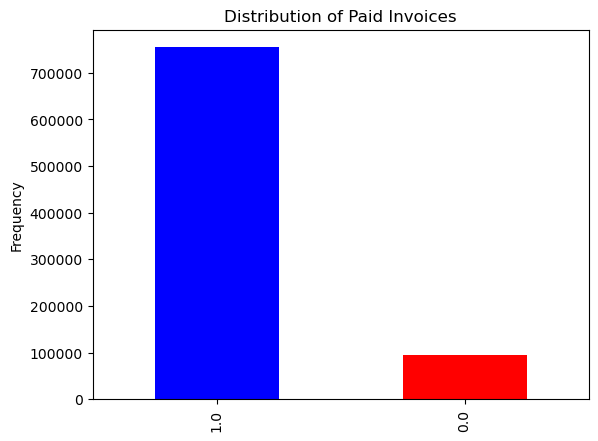

In [39]:
# Let's observe the distribution of our target variable.
df['COLLECTED'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.xlabel('')
plt.ylabel('Frequency')
plt.title('Distribution of Paid Invoices')
plt.show()

In [40]:
# Drop values with high multicollinearity for a better model, this is the last prrocess of data cleaning.
# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Dropping non-numeric and target columns for VIF calculation
numeric_features = df.drop(columns=['COLLECTED']).select_dtypes(include=[np.number])

# Calculating VIF for numeric features
vif_data = calculate_vif(numeric_features)

# Displaying the VIF data
vif_data = vif_data.sort_values(by='VIF', ascending=False).head(10)
vif_data

,Feature,VIF
11,ER_USD,1895.812057
10,ER_SDR,1866.228083
15,GDP_R,144.938700
14,GDP_N,132.104762
16,GDP_N_ChangeRate,8.943220
17,GDP_R_ChangeRate,6.714922
12,IR,6.360129
18,Inflation,4.252257
20,HDI,1.974559
19,Population,1.878166


In [41]:
# Drop the values with high VIF and check again
df = df.drop(columns=['ER_USD','ER_SDR', 'GDP_R', 'GDP_N_ChangeRate'])

# Dropping non-numeric and target columns for VIF calculation
numeric_features = df.drop(columns=['COLLECTED']).select_dtypes(include=[np.number])

# Calculating VIF for numeric features
vif_data = calculate_vif(numeric_features)

# Displaying the VIF data
vif_data = vif_data.sort_values(by='VIF', ascending=False).head(10)
vif_data

,Feature,VIF
10,IR,4.870076
14,Inflation,3.683927
16,HDI,1.799476
15,Population,1.636024
11,UR,1.276050
12,GDP_N,1.230754
1,SUPPLIER_BAD_DEBT,1.128283
0,SUPPLIER_BANKRUPTCY,1.109233
9,CORONAVIRUS_PERIOD,1.106463
3,SUPPLIER_HAS_GROUP,1.101231


In [42]:
# Analyze the VIF, but now for the model without macroeconomic variables
# Dropping non-numeric and target columns for VIF calculation
numeric_features = df_2.drop(columns=['COLLECTED']).select_dtypes(include=[np.number])

# Calculating VIF for numeric features
vif_data = calculate_vif(numeric_features)

# Displaying the VIF data
vif_data = vif_data.sort_values(by='VIF', ascending=False).head(10)
vif_data

,Feature,VIF
6,INVOICE_FEE_EUROS,8.642465
1,SUPPLIER_BAD_DEBT,1.120989
0,SUPPLIER_BANKRUPTCY,1.107441
2,SUPPLIER_RECONCILED,1.093866
3,SUPPLIER_HAS_GROUP,1.070882
5,SUPPLIER_EVER_BLOCKED,1.039124
7,DAYS_DIFFERENCE,1.015782
4,SUPPLIER_LOGISTICS,1.009229
9,CORONAVIRUS_PERIOD,1.004903
8,YEAR_DATE_INVOICE,0.000012


In [43]:
# The non-macroeconomic model does not have high VIF, we do not need to drop more variables
# We save the final data model into a CSV file.
# df.to_csv('data_modified.csv', index=False)
# df_2.to_csv('data_original_modified.csv', index=False)

#Save modified file with only 5 percent of data for faster testing
#sampled_df = df.sample(frac=0.05, random_state=1)  # random_state for reproducibility

# Save the sampled DataFrame back to an Excel file
#sampled_df.to_csv('sampled_data.csv', index=False)

# <a id='4'>Model Selection</a>

For the modeling and hyperparameter optimization phase, multiple experiments were conducted to identify the optimal model.
The detailed code and testing process are not included here, as they involve extensive computations and would result in a lengthy analysis if executed.
In total, over six models were evaluated, including Random Forest, Gradient Boosting, K-Nearest Neighbors, Logistic Regression, AdaBoost, and Support Vector Machine, using hyperparameter tuning via Randomized Search Cross-Validation to select the best-performing configuration.


In [44]:
### Running the Model ###

# Record the start time
start_time = time.time()

# Sample 5 percent of the DataFrame for quick testing
# df = df.sample(frac=0.2, random_state=4)  # random_state for reproducibility

# Doing one-hot encoding to the categorical variables (variables of type object)
df = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns)

# Separate features and target variable
X = df.drop(columns=['COLLECTED'])
y = df['COLLECTED']

# Split the data into training (80%) and testing (20%) sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Split the training data into training (75%) and validation (25%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=4)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

param_grids = {
    "Gradient Boosting": {
        'n_estimators': [150, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [5]
    },
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_features': ['log2'],
        'max_depth': [10],
        'bootstrap': [True]
    }
}

# Models to tune
models = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(random_state=4),
}

# Dictionary to hold results
results = {}

# Train and evaluate each model with hyperparameter tuning using RandomizedSearchCV
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    param_grid = param_grids[model_name]
    random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=4)
    random_search.fit(X_train, y_train)
    
    # Best model from random search
    best_model = random_search.best_estimator_
    
    # Predict on the validation set
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_report = classification_report(y_val, y_val_pred)
    
    results[model_name] = {
        "Validation Accuracy": val_accuracy,
        "Validation Report": val_report,
        "Best Parameters": random_search.best_params_
    }

# Display the results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Validation Accuracy: {result['Validation Accuracy']}")
    print("Validation Classification Report:")
    print(result['Validation Report'])
    print("-" * 80)

# Record the end time
end_time = time.time()

# Calculate the duration
duration = end_time - start_time

print(f"Total duration: {duration} seconds")

Tuning Gradient Boosting...


C:\Users\beltr\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning Random Forest...


C:\Users\beltr\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model: Gradient Boosting
Best Parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
Validation Accuracy: 0.926359783376501
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.52      0.61      3763
         1.0       0.94      0.98      0.96     30213

    accuracy                           0.93     33976
   macro avg       0.84      0.75      0.78     33976
weighted avg       0.92      0.93      0.92     33976

--------------------------------------------------------------------------------
Model: Random Forest
Best Parameters: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Validation Accuracy: 0.8678773251707087
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.43      0.60      0.50      3763
         1.0       0.95      0.90      0.92     30213

    accuracy                           0.87     33976
   ma

In [ ]:
# Save the best model trained
for model_name, result in results.items():
    # Create a model instance with the best parameters
    model_class = models[model_name]  # original untrained model
    trained_model = model_class.set_params(**result["Best Parameters"])
    
    # Fit the model on the full training data
    trained_model.fit(X_train_full, y_train_full)
    
    # Store the trained model in results
    results[model_name]["Final Model"] = trained_model
    
    # Save the trained model to disk
    # filename = 'final_model_' + model_name.replace(' ', '_').lower() + '.pkl'
    # joblib.dump(trained_model, filename)


In [ ]:
# Load the models
# rf_model = joblib.load("random_forest_final_model.pkl")
# gb_model = joblib.load("gradient_boosting_final_model.pkl")

In [48]:
### Modelling the model without macro variables ###

# Record the start time
start_time = time.time()

# Sample 10 percent of the DataFrame for quick testing
# df_2 = df_2.sample(frac=0.1, random_state=1)  # random_state for reproducibility

# Doing one-hot encoding to the categorical variables (variables of type object)
df_2 = pd.get_dummies(df_2, columns=df_2.select_dtypes(include=['object']).columns)

# Separate features and target variable
X_2 = df_2.drop(columns=['COLLECTED'])
y_2 = df_2['COLLECTED']

# Split the data into training (80%) and testing (20%) sets
X_2_train_full, X_2_test, y_2_train_full, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=4)

# Split the training data into training (75%) and validation (25%) sets
X_2_train, X_2_val, y_2_train, y_2_val = train_test_split(X_2_train_full, y_2_train_full, test_size=0.25, random_state=4)

# Apply SMOTE to the training data
#smote = SMOTE(random_state=4)
#X_2_train, y_2_train = smote.fit_resample(X_2_train, y_2_train)

param_grids_2 = {
    "Gradient Boosting": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5]
    },
    "Random Forest": {
        'n_estimators': [50, 100, 150],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 15, 20],
        'class_weight': ['balanced', 'balanced_subsample'],
        'bootstrap': [True]
    },
    "Logistic Regression": {
        'penalty': ['l2', 'none'],
        'C': [1, 10],
        'solver': ['liblinear', 'saga']
    },
    "k-Nearest Neighbors": {
        'n_neighbors': [3, 5],
        'weights': ['uniform'],
        'metric': ['euclidean', 'manhattan']
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.05, 0.1, 1]
    }
}

# Models to tune
models_2 = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(random_state=4),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(random_state=4)
}

# Dictionary to hold results
results_2 = {}

# Train and evaluate each model with hyperparameter tuning using RandomizedSearchCV
for model_name, model in models_2.items():
    print(f"Tuning {model_name} on df_2...")
    param_grid = param_grids_2[model_name]
    random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=4)
    random_search.fit(X_2_train, y_2_train)
    
    # Best model from random search
    best_model_2 = random_search.best_estimator_
    
    # Predict on the validation set
    y_2_val_pred = best_model_2.predict(X_2_val)
    val_accuracy = accuracy_score(y_2_val, y_2_val_pred)
    val_report = classification_report(y_2_val, y_2_val_pred)
    
    results_2[model_name] = {
        "Validation Accuracy": val_accuracy,
        "Validation Report": val_report,
        "Best Parameters": random_search.best_params_
    }

# Display the results
for model_name, result in results_2.items():
    print(f"Model: {model_name} on df_2")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Validation Accuracy: {result['Validation Accuracy']}")
    print("Validation Classification Report:")
    print(result['Validation Report'])
    print("-" * 80)

# Record the end time
end_time = time.time()

# Calculate the duration
duration = end_time - start_time

print(f"Total duration: {duration} seconds")

Tuning Gradient Boosting on df_2...
Tuning Random Forest on df_2...
Tuning Logistic Regression on df_2...


C:\Users\beltr\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\beltr\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\beltr\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\beltr\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\beltr\anaconda3\Lib\site-packages\sklearn\linear_mod

Tuning k-Nearest Neighbors on df_2...
Tuning AdaBoost on df_2...
Model: Gradient Boosting on df_2
Best Parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.05}
Validation Accuracy: 0.9111241907004121
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.33      0.47       203
           1       0.92      0.99      0.95      1496

    accuracy                           0.91      1699
   macro avg       0.86      0.66      0.71      1699
weighted avg       0.90      0.91      0.89      1699

--------------------------------------------------------------------------------
Model: Random Forest on df_2
Best Parameters: {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced', 'bootstrap': True}
Validation Accuracy: 0.8958210712183637
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.31      0.42       203
     

In [49]:
df.shape

(169880, 112)

In [50]:
df_2.shape

(8494, 106)

# <a id='5'>Model Evaluation</a>

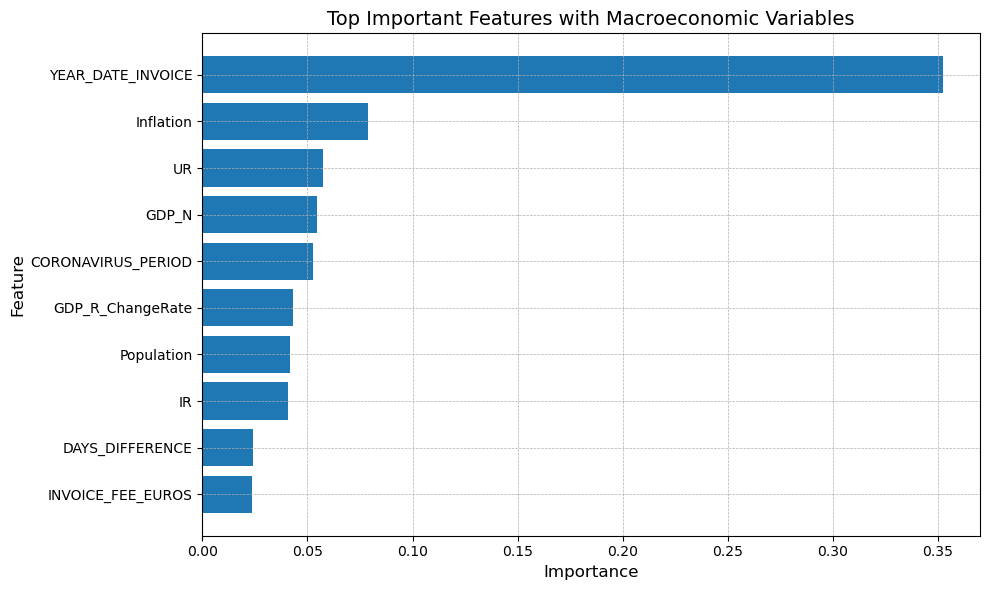

               Feature  Importance
8    YEAR_DATE_INVOICE    0.352474
14           Inflation    0.078801
11                  UR    0.057348
12               GDP_N    0.054746
9   CORONAVIRUS_PERIOD    0.052476
13    GDP_R_ChangeRate    0.043118
15          Population    0.041523
10                  IR    0.040908
7      DAYS_DIFFERENCE    0.024068
6    INVOICE_FEE_EUROS    0.023837


In [51]:
# Extracting feature importances
feature_importances = best_model.feature_importances_
features = X.columns

# Creating a dataframe for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Displaying the top 10 important features
top_10_features = importance_df.head(10)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top Important Features with Macroeconomic Variables', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Display the dataframe with the top 10 important features
print(top_10_features)


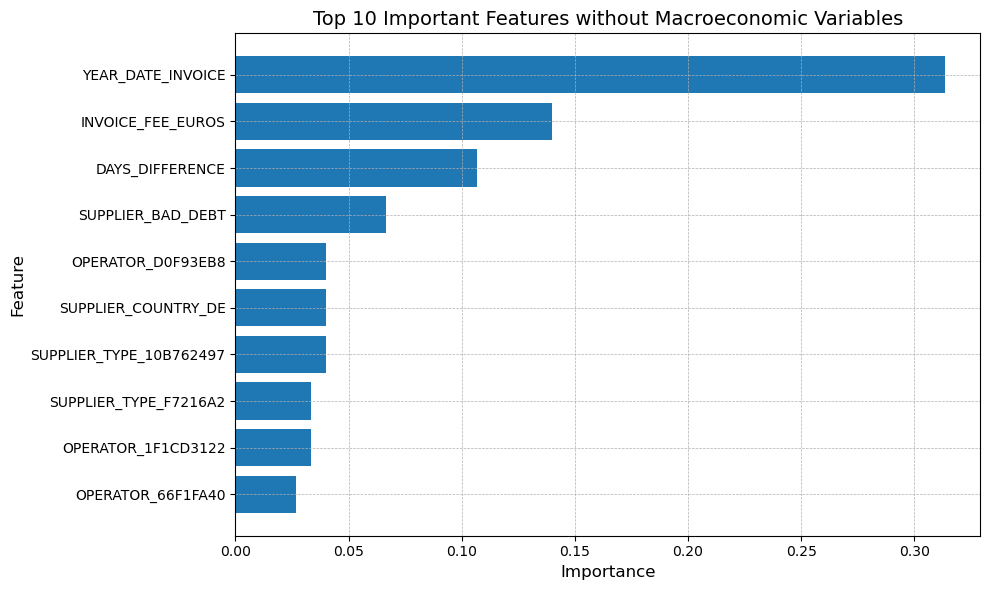

                    Feature  Importance
8         YEAR_DATE_INVOICE    0.313333
6         INVOICE_FEE_EUROS    0.140000
7           DAYS_DIFFERENCE    0.106667
1         SUPPLIER_BAD_DEBT    0.066667
58        OPERATOR_D0F93EB8    0.040000
67      SUPPLIER_COUNTRY_DE    0.040000
86  SUPPLIER_TYPE_10B762497    0.040000
90    SUPPLIER_TYPE_F7216A2    0.033333
41       OPERATOR_1F1CD3122    0.033333
50        OPERATOR_66F1FA40    0.026667


In [52]:
# Extracting feature importances for model without macroeconomic variables
feature_importances = best_model_2.feature_importances_
features = X_2.columns

# Creating a dataframe for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Displaying the top 10 important features
top_10_features = importance_df.head(10)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Important Features without Macroeconomic Variables', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Display the dataframe with the top 10 important features
print(top_10_features)


Model: Gradient Boosting
Best Parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
Test Accuracy: 0.9325994819872852
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.50      0.62      3731
         1.0       0.94      0.99      0.96     30245

    accuracy                           0.93     33976
   macro avg       0.88      0.74      0.79     33976
weighted avg       0.93      0.93      0.93     33976

Confusion Matrix:
[[ 1879  1852]
 [  438 29807]]
--------------------------------------------------------------------------------


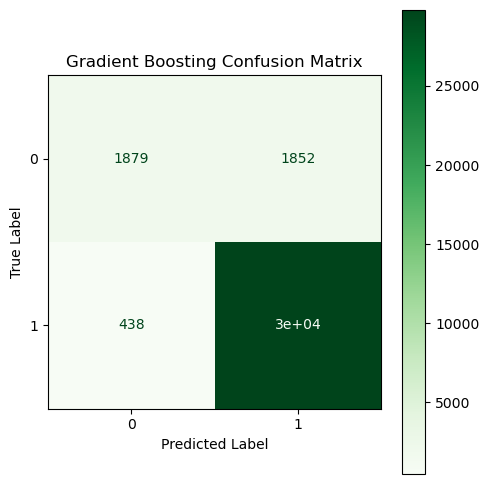

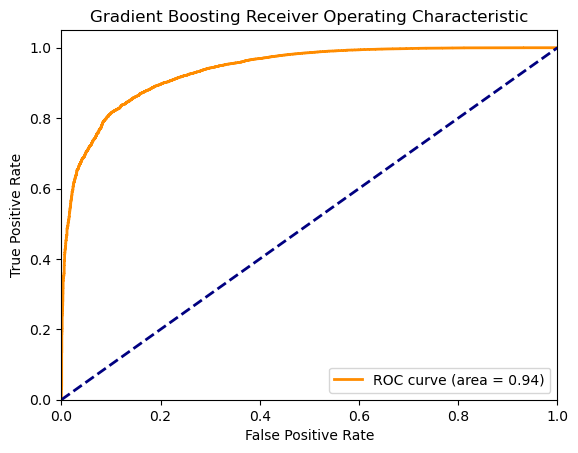

Model: Random Forest
Best Parameters: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Test Accuracy: 0.9059630327289852
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.17      0.28      3731
         1.0       0.91      1.00      0.95     30245

    accuracy                           0.91     33976
   macro avg       0.89      0.58      0.62     33976
weighted avg       0.90      0.91      0.88     33976

Confusion Matrix:
[[  624  3107]
 [   88 30157]]
--------------------------------------------------------------------------------


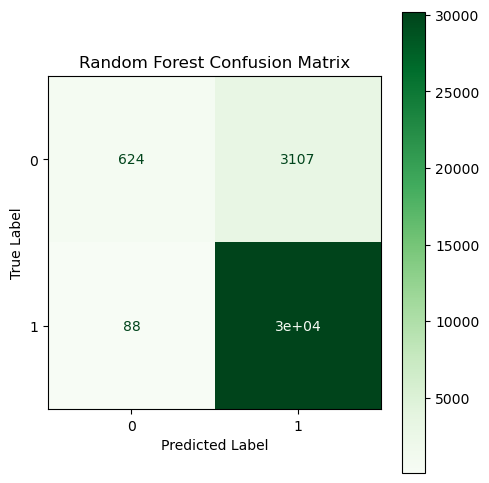

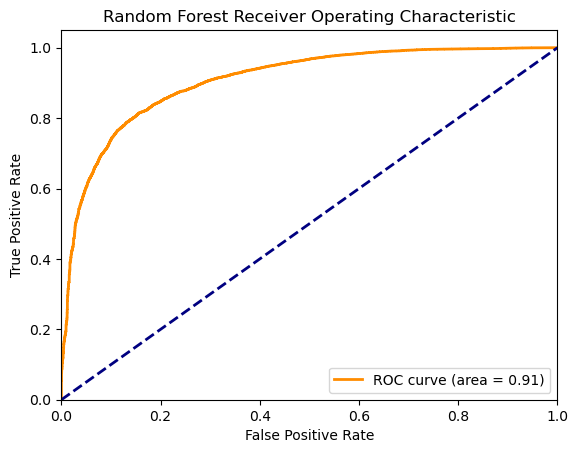

In [53]:
### Model Evaluation ###

# Use the best model to predict on the test set
for model_name, result in results.items():
    # Retrieve the best model with the best parameters
    best_model = models[model_name].set_params(**result["Best Parameters"])
    
    # Fit the best model on the full training data
    best_model.fit(X_train_full, y_train_full)
    
    # Predict on the test set
    y_test_pred = best_model.predict(X_test)
    
    # Evaluate the performance on the test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    
    # Calculate ROC curve and AUC
    y_test_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)
    
    # Display the results
    print(f"Model: {model_name}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Test Accuracy: {test_accuracy}")
    print("Test Classification Report:")
    print(test_report)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("-" * 80)
    
    fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(ax=ax, cmap=plt.cm.Greens)  # Change the colormap

    # Customize the display
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.tight_layout()  # Adjust the layout to fit everything neatly
    plt.show()
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


Model: Gradient Boosting on df_2
Best Parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.05}
Test Accuracy: 0.9158328428487346
Test Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.32      0.46       192
           1       0.92      0.99      0.95      1507

    accuracy                           0.92      1699
   macro avg       0.88      0.65      0.71      1699
weighted avg       0.91      0.92      0.90      1699

Confusion Matrix:
[[  61  131]
 [  12 1495]]
--------------------------------------------------------------------------------


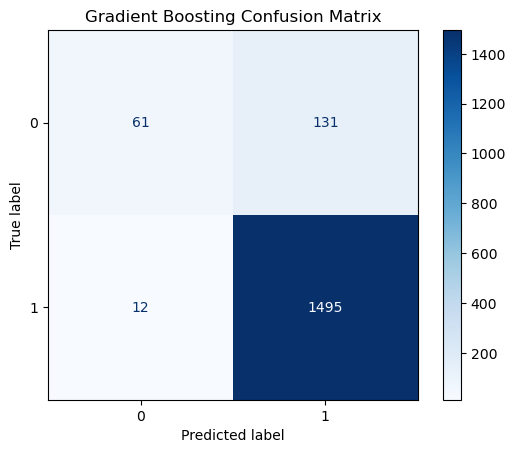

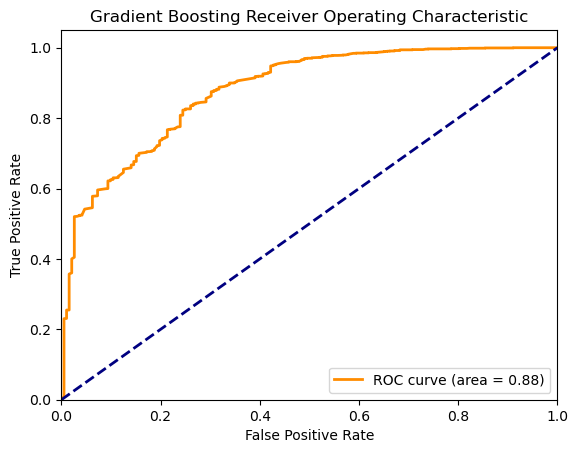

Model: Random Forest on df_2
Best Parameters: {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced', 'bootstrap': True}
Test Accuracy: 0.8928781636256622
Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.38      0.44       192
           1       0.92      0.96      0.94      1507

    accuracy                           0.89      1699
   macro avg       0.73      0.67      0.69      1699
weighted avg       0.88      0.89      0.88      1699

Confusion Matrix:
[[  72  120]
 [  62 1445]]
--------------------------------------------------------------------------------


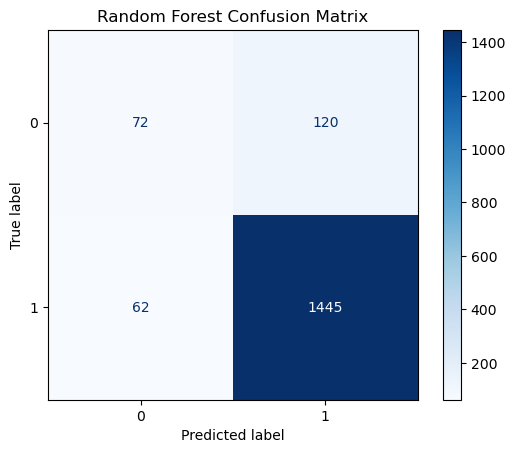

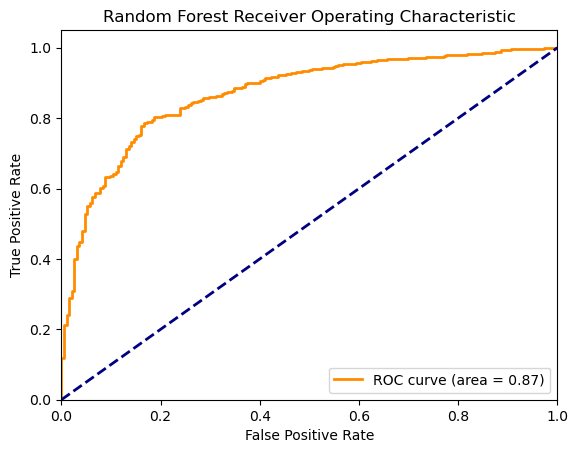

Model: Logistic Regression on df_2
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}
Test Accuracy: 0.8816951147733961
Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       192
           1       0.89      0.99      0.94      1507

    accuracy                           0.88      1699
   macro avg       0.44      0.50      0.47      1699
weighted avg       0.79      0.88      0.83      1699

Confusion Matrix:
[[   0  192]
 [   9 1498]]
--------------------------------------------------------------------------------


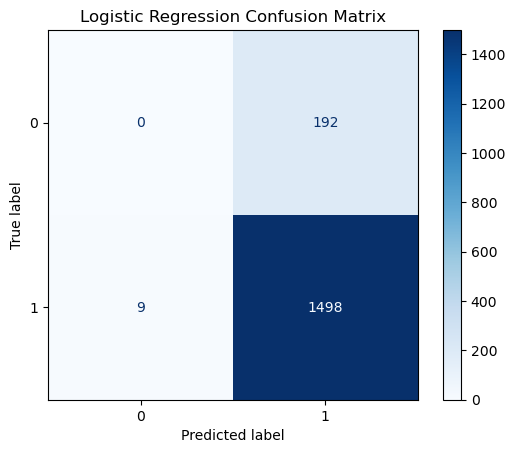

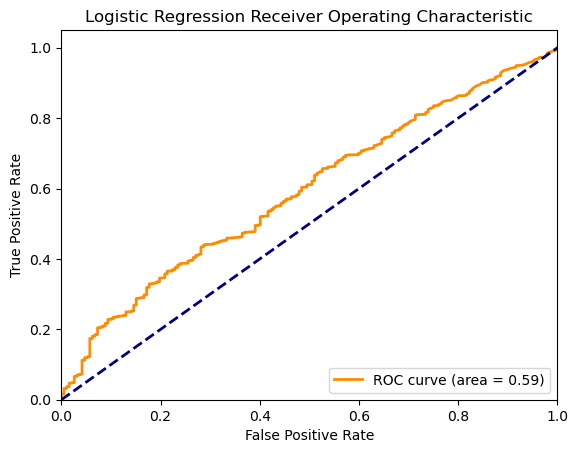

Model: k-Nearest Neighbors on df_2
Best Parameters: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'euclidean'}
Test Accuracy: 0.8716892289582107
Test Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.03      0.05       192
           1       0.89      0.98      0.93      1507

    accuracy                           0.87      1699
   macro avg       0.52      0.51      0.49      1699
weighted avg       0.81      0.87      0.83      1699

Confusion Matrix:
[[   6  186]
 [  32 1475]]
--------------------------------------------------------------------------------


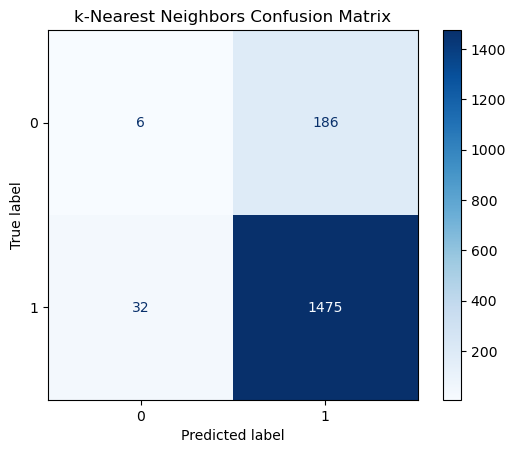

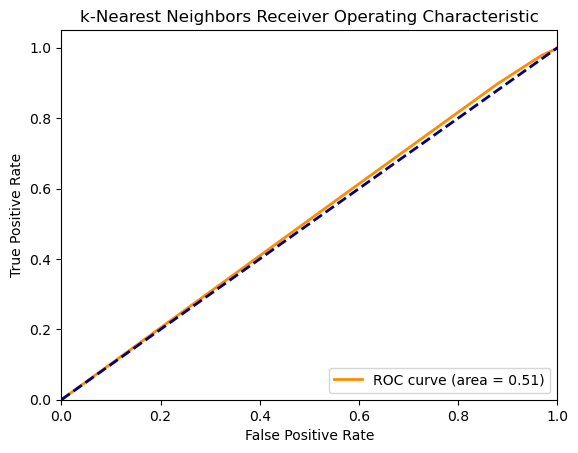

Model: AdaBoost on df_2
Best Parameters: {'n_estimators': 150, 'learning_rate': 0.1}
Test Accuracy: 0.9140670982931136
Test Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.31      0.45       192
           1       0.92      0.99      0.95      1507

    accuracy                           0.91      1699
   macro avg       0.87      0.65      0.70      1699
weighted avg       0.91      0.91      0.90      1699

Confusion Matrix:
[[  59  133]
 [  13 1494]]
--------------------------------------------------------------------------------


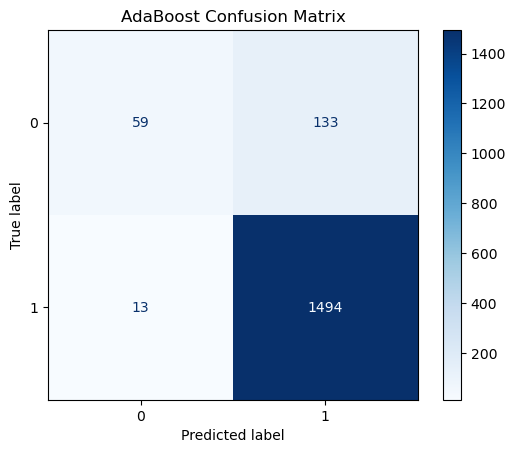

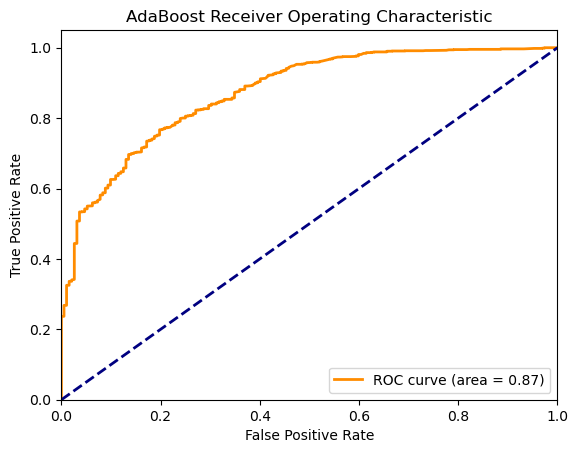

In [54]:
# Use the best model to predict on the test set
for model_name, result in results_2.items():
    # Retrieve the best parameters for the model
    best_model_2 = models_2[model_name].set_params(**result["Best Parameters"])
    
    # Fit the best model on the full training data
    best_model_2.fit(X_2_train_full, y_2_train_full)
    
    # Predict on the test set
    y_2_test_pred = best_model_2.predict(X_2_test)
    
    # Evaluate the performance on the test set
    test_accuracy_2 = accuracy_score(y_2_test, y_2_test_pred)
    test_report_2 = classification_report(y_2_test, y_2_test_pred)
    conf_matrix = confusion_matrix(y_2_test, y_2_test_pred)
    
    # Calculate ROC curve and AUC
    y_2_test_prob = best_model_2.predict_proba(X_2_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_2_test, y_2_test_prob)
    roc_auc = auc(fpr, tpr)
    
    # Display the results
    print(f"Model: {model_name} on df_2")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Test Accuracy: {test_accuracy_2}")
    print("Test Classification Report:")
    print(test_report_2)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("-" * 80)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


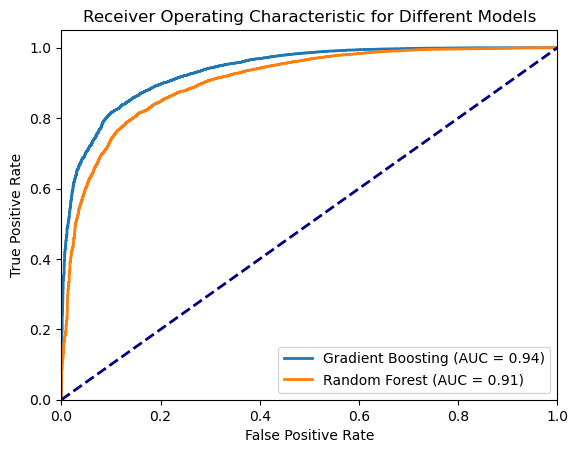

In [55]:
# Initialize the plot
plt.figure()

# Iterate through each model and plot the ROC curve
for model_name, result in results.items():
    # Retrieve the best model with the best parameters
    best_model = models[model_name].set_params(**result["Best Parameters"])
    
    # Fit the best model on the full training data
    best_model.fit(X_train_full, y_train_full)
    
    # Predict the probabilities on the test set
    y_test_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for the current model
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Different Models')

# Show legend
plt.legend(loc="lower right")

# Show the plot
plt.show()

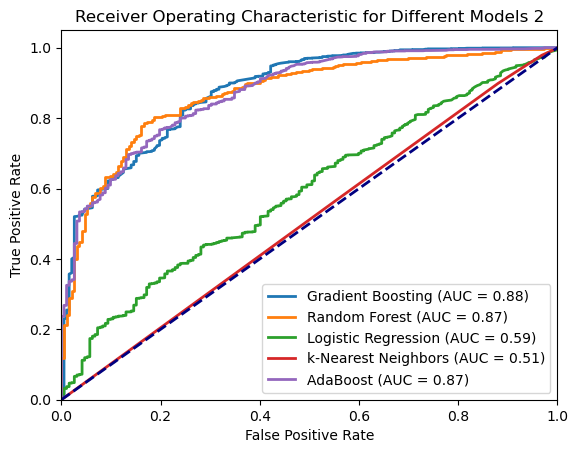

In [56]:
# Initialize the plot for model without macroeconomic variables
plt.figure()

# Iterate through each model and plot the ROC curve
for model_name, result in results_2.items():
    # Retrieve the best parameters for the model
    best_model_2 = models_2[model_name].set_params(**result["Best Parameters"])
    
    # Fit the best model on the full training data
    best_model_2.fit(X_2_train_full, y_2_train_full)
    
    # Predict the probabilities on the test set
    y_2_test_prob = best_model_2.predict_proba(X_2_test)[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_2_test, y_2_test_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for the current model
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Different Models 2')

# Show legend
plt.legend(loc="lower right")

# Show the plot
plt.show()


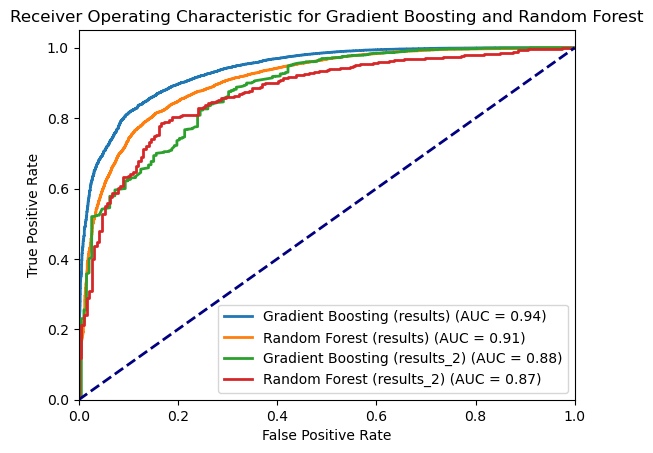

In [57]:
# Initialize the plot for macroeconomic variables
plt.figure()

# Define the models to plot
models_to_plot = ["Gradient Boosting", "Random Forest"]

# Plot ROC curves for models from results
for model_name in models_to_plot:
    if model_name in results:
        result = results[model_name]
        best_model = models[model_name].set_params(**result["Best Parameters"])
        
        # Fit the best model on the full training data
        best_model.fit(X_train_full, y_train_full)
        
        # Predict the probabilities on the test set
        y_test_prob = best_model.predict_proba(X_test)[:, 1]
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_test_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve for the current model
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (results) (AUC = {roc_auc:.2f})')

# Plot ROC curves for models from results_2
for model_name in models_to_plot:
    if model_name in results_2:
        result = results_2[model_name]
        best_model_2 = models_2[model_name].set_params(**result["Best Parameters"])
        
        # Fit the best model on the full training data
        best_model_2.fit(X_2_train_full, y_2_train_full)
        
        # Predict the probabilities on the test set
        y_2_test_prob = best_model_2.predict_proba(X_2_test)[:, 1]
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_2_test, y_2_test_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve for the current model
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (results_2) (AUC = {roc_auc:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Gradient Boosting and Random Forest')

# Show legend
plt.legend(loc="lower right")

# Show the plot
plt.show()

Model: Gradient Boosting
Best Parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
Test Accuracy: 0.9326289145279021
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.50      0.62      3731
         1.0       0.94      0.99      0.96     30245

    accuracy                           0.93     33976
   macro avg       0.88      0.74      0.79     33976
weighted avg       0.93      0.93      0.93     33976

Confusion Matrix:
[[ 1879  1852]
 [  437 29808]]
--------------------------------------------------------------------------------


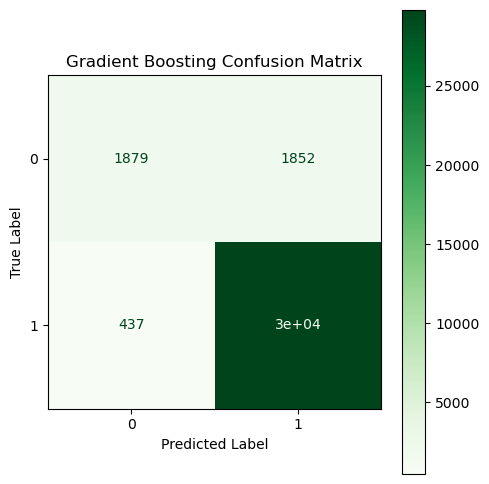

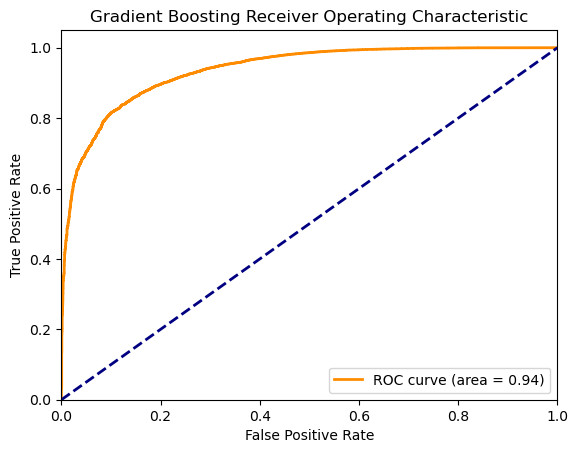

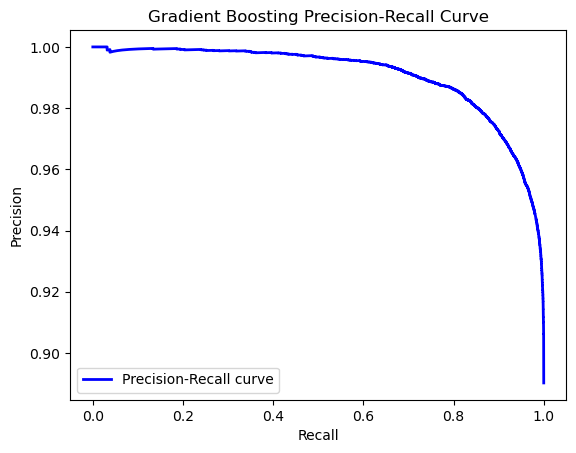

Model: Random Forest
Best Parameters: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Test Accuracy: 0.9059630327289852
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.17      0.28      3731
         1.0       0.91      1.00      0.95     30245

    accuracy                           0.91     33976
   macro avg       0.89      0.58      0.62     33976
weighted avg       0.90      0.91      0.88     33976

Confusion Matrix:
[[  624  3107]
 [   88 30157]]
--------------------------------------------------------------------------------


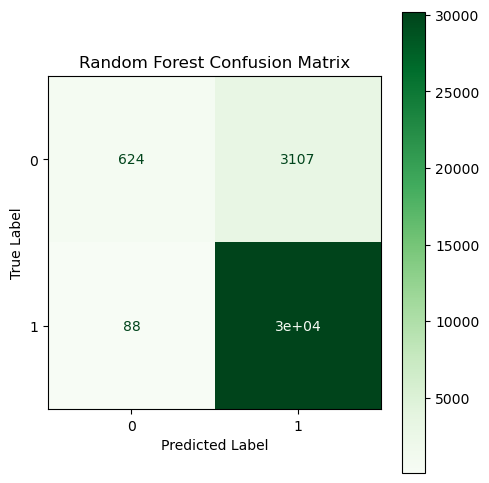

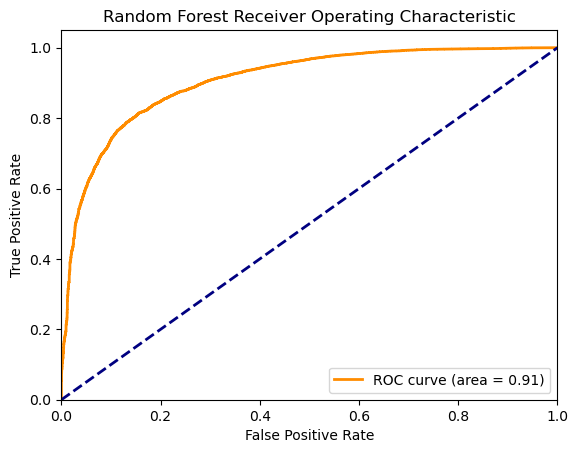

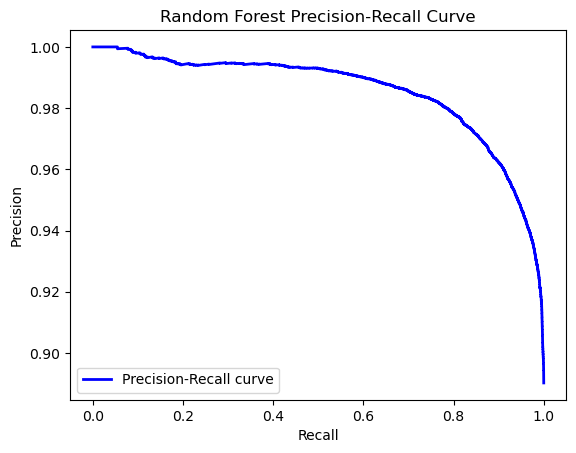

In [58]:
# Use the best model to predict on the test set
for model_name, result in results.items():
    # Retrieve the best model with the best parameters
    best_model = models[model_name].set_params(**result["Best Parameters"])
    
    # Fit the best model on the full training data
    best_model.fit(X_train_full, y_train_full)
    
    # Predict on the test set
    y_test_pred = best_model.predict(X_test)
    
    # Evaluate the performance on the test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    
    # Calculate ROC curve and AUC
    y_test_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)
    
    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
    
    # Display the results
    print(f"Model: {model_name}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Test Accuracy: {test_accuracy}")
    print("Test Classification Report:")
    print(test_report)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("-" * 80)
    
    fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(ax=ax, cmap=plt.cm.Greens)  # Change the colormap

    # Customize the display
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.tight_layout()  # Adjust the layout to fit everything neatly
    plt.show()
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()


The models are integrated in the workflow of the company to generate a monthly report that presents a forecast analysis